In [2]:
import os
from pathlib import Path

import contextily as cx
import geopandas as gpd
import hdbscan
import matplotlib as mpl
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

In [3]:
data_path = Path(os.environ["DATA_PATH"])

ZONE = "19.1.01"

In [4]:
df_points = gpd.read_file(data_path / "generated" / "denue" / "split" / f"{ZONE}.gpkg")

In [5]:
def alpha_cmap(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    # Set a square root alpha.
    x = np.linspace(0.5, 1, cmap.N)
    my_cmap[:, -1] = x ** (0.5)
    return mcol.ListedColormap(my_cmap)

In [6]:
coords = df_points.get_coordinates()

xmin = coords["x"].min() - 500
xmax = coords["x"].max() + 500
ymin = coords["y"].min() - 1000
ymax = coords["y"].max() + 3000

width = 10
height = width * (ymax - ymin) / (xmax - xmin)

KeyboardInterrupt: 

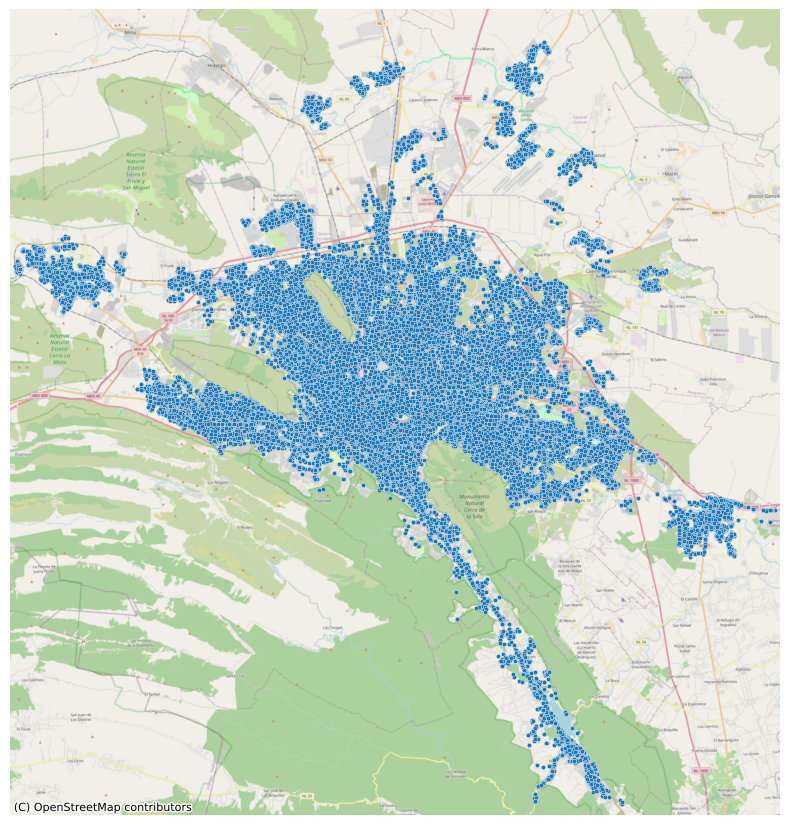

In [8]:
fig, ax = plt.subplots(figsize=(width, height))
df_points.plot(ax=ax, markersize=10, c="C0", ec="white", lw=0.25, autolim=False)

ax.axis("off")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cx.add_basemap(ax, crs=df_points.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12)
fig.savefig("./figures/points.jpg", dpi=300, bbox_inches="tight")

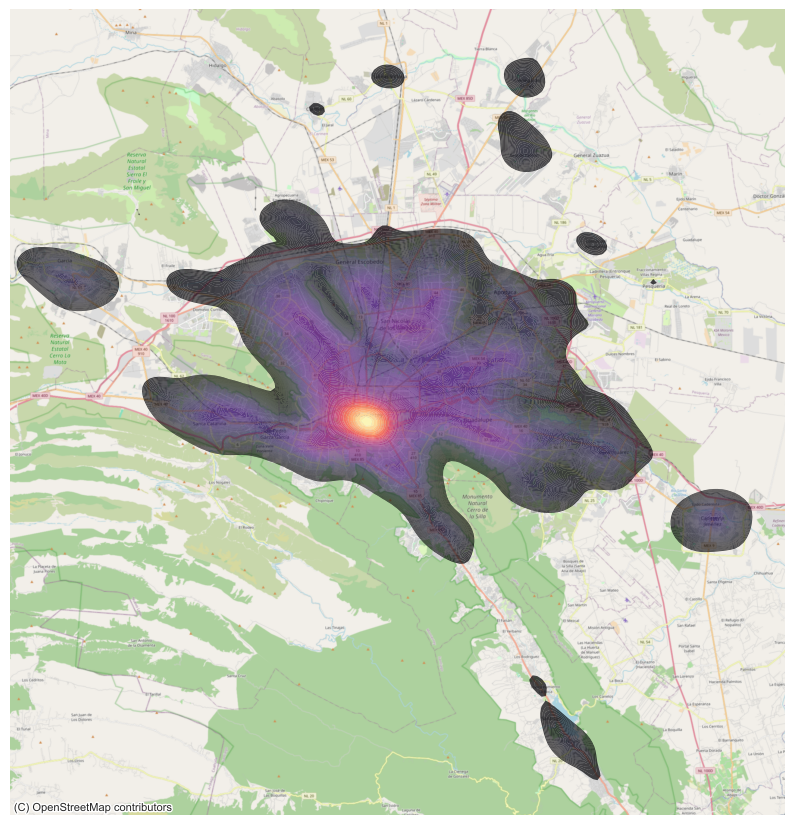

In [159]:
fig, ax = plt.subplots(figsize=(width, height))
sns.kdeplot(
    x=coords["x"],
    y=coords["y"],
    fill=True,
    cmap=alpha_cmap(mpl.colormaps["magma"]),
    levels=200,
    antialiased=True,
    ax=ax,
)
ax.axis("off")
for line in ax.get_lines():
    line.set_alpha(0)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cx.add_basemap(ax, crs=df_points.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12)
fig.savefig("./figures/kde.jpg", dpi=300, bbox_inches="tight")

In [164]:
df_points_filtered = gpd.read_file(
    data_path / "generated" / "coarse" / "points" / "base" / f"{ZONE}.gpkg",
)

df_points_clean = df_points_filtered.query("label != -1")
df_points_dirty = df_points_filtered.query("label == -1")

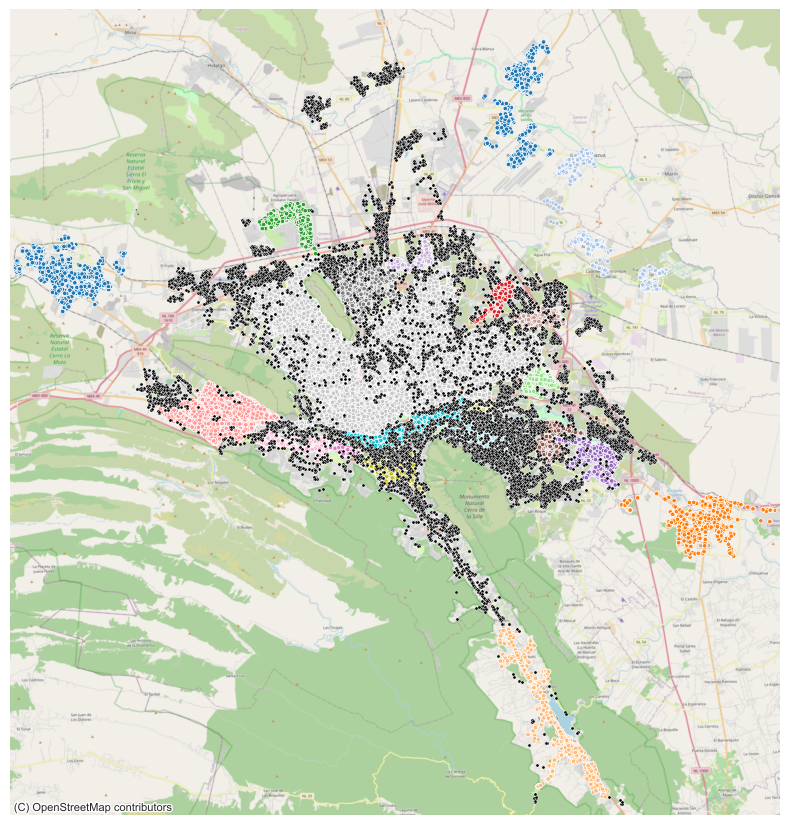

In [167]:
fig, ax = plt.subplots(figsize=(width, height))
df_points_clean.plot(
    column="label",
    categorical=True,
    legend=False,
    markersize=10,
    ax=ax,
    ec="white",
    lw=0.5,
    autolim=False,
    cmap="tab20",
)

df_points_dirty.plot(
    color="black",
    markersize=5,
    ax=ax,
    ec="white",
    lw=0.25,
    autolim=False,
)

ax.axis("off")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cx.add_basemap(ax, crs=df_points.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12)
fig.savefig("./figures/clustered_points.jpg", dpi=300, bbox_inches="tight")

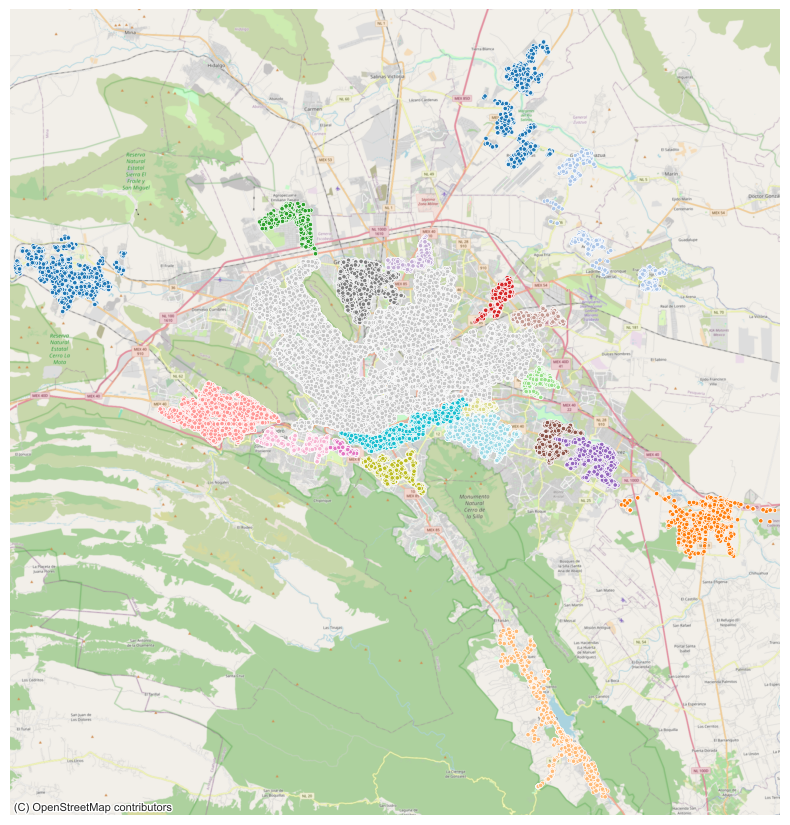

In [168]:
fig, ax = plt.subplots(figsize=(width, height))
df_points_clean.plot(
    column="label",
    categorical=True,
    legend=False,
    markersize=10,
    ax=ax,
    ec="white",
    lw=0.5,
    autolim=False,
    cmap="tab20",
)
ax.axis("off")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cx.add_basemap(ax, crs=df_points.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12)
fig.savefig("./figures/clustered_points_clean.jpg", dpi=300, bbox_inches="tight")

In [ ]:
df_polygons = gpd.read_file(
    data_path / "generated" / "coarse" / "polygons" / "base" / f"{ZONE}.gpkg",
)

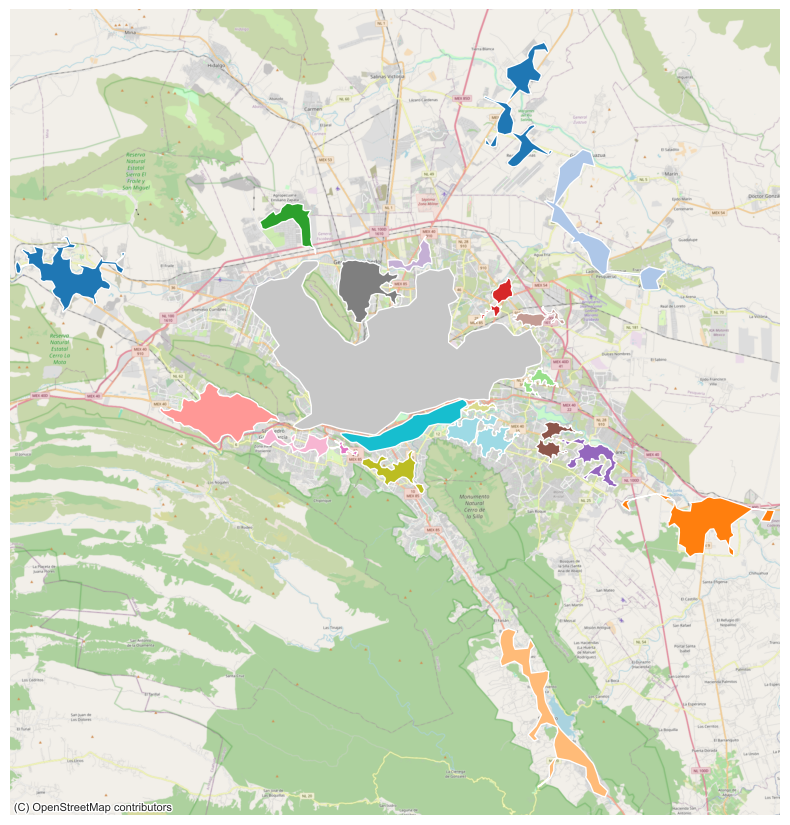

In [171]:
fig, ax = plt.subplots(figsize=(width, height))
df_polygons.plot(ax=ax, cmap="tab20")
ax.axis("off")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cx.add_basemap(ax, crs=df_points.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12)
fig.savefig("./figures/polygons.jpg", dpi=300, bbox_inches="tight")

In [195]:
df_polygons["medoid"].unique()

array([1, 0, 2, 3])

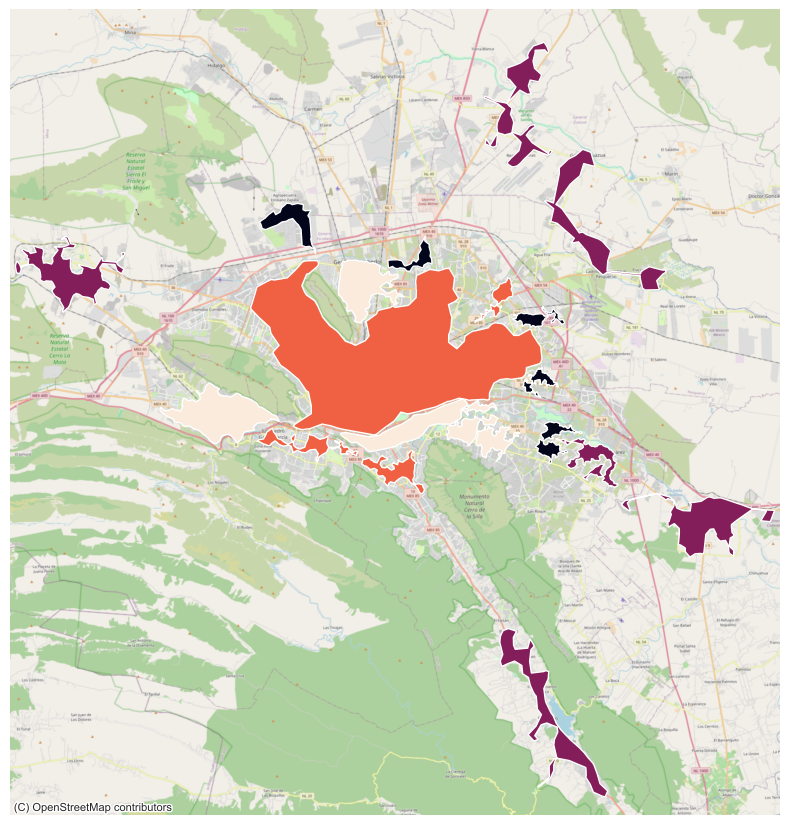

In [194]:
fig, ax = plt.subplots(figsize=(width, height))
df_polygons.plot(ax=ax, column="medoid")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")
cx.add_basemap(ax, crs=df_points.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=12)
fig.savefig("./figures/polygons_medoid.jpg", dpi=300, bbox_inches="tight")

/var/folders/yq/0mz24vy927s9m5vjh6gqb6040000gn/T/ipykernel_20002/1793790621.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1200)


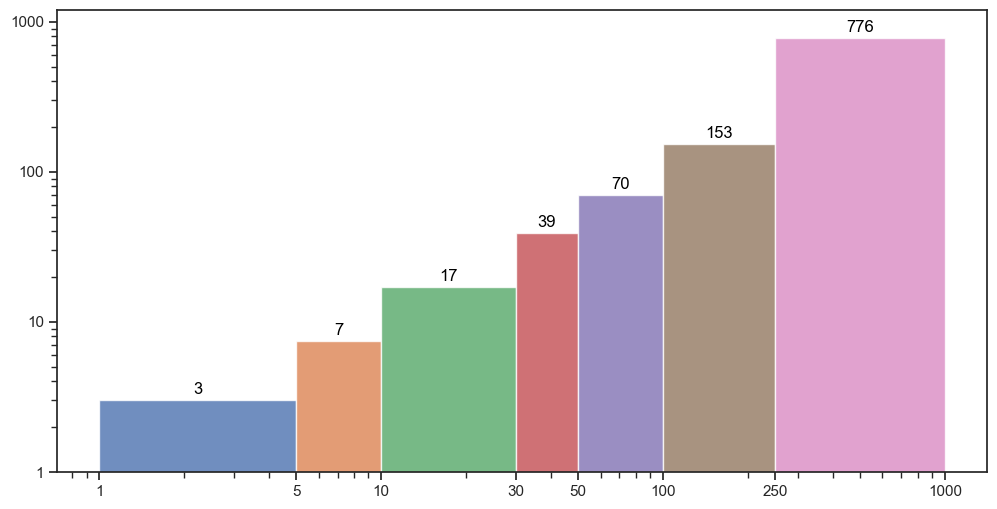

In [ ]:
sns.set_theme(style="ticks")

rows = [
    [1, 5, 3],
    [5, 10, 7.461575],
    [10, 30, 17.032184],
    [30, 50, 38.811196],
    [50, 100, 69.780408],
    [100, 250, 153.000738],
    [250, 1000, 775.748274],
]

df_approx = pd.DataFrame(rows, columns=["lower", "upper", "pareto"])

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xscale("log")
ax.set_yscale("log")
for _, row in df_approx.iterrows():
    ax.fill_between(
        [row["lower"], row["upper"]],
        [0, 0],
        [row["pareto"], row["pareto"]],
        alpha=0.8,
    )
    # Use log midpoint for better centering on log scale
    x_center = np.sqrt(row["lower"] * row["upper"])
    ax.text(
        x_center,
        row["pareto"] * 1.05,  # Slightly above the region
        f"{int(round(row['pareto']))}",
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
    )

ticks = [p[0] for p in rows] + [rows[-1][1]]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

ax.set_yticks([1, 10, 100, 1000])
ax.set_yticklabels([1, 10, 100, 1000])
ax.set_ylim(0, 1200)

fig.savefig(
    "./figures/pareto_approximation.jpg",
    dpi=300,
    bbox_inches="tight",
)

# Distance matrix

In [177]:
df_points_mat = gpd.read_file(
    data_path / "generated" / "coarse" / "points" / "remove_unused" / f"{ZONE}.gpkg",
)
df_polygons_mat = gpd.read_file(
    data_path / "generated" / "coarse" / "polygons" / "base" / f"{ZONE}.gpkg",
)

In [178]:
df_cross = (
    df_points_mat.assign(
        category=lambda df: df["codigo_act"].astype(str).str[:2].astype(int),
    )
    .groupby(["label", "category"])["codigo_act"]
    .count()
    .reset_index()
    .pivot_table(index="label", columns="category", values="codigo_act")
    .fillna(0)
    .astype(int)
)
labels = df_cross.index.tolist()

In [183]:
mat = df_cross.to_numpy()
mat = mat / mat.sum(axis=1)[:, np.newaxis]

dist_mat = np.zeros((len(mat), len(mat)))
for i, start_row in enumerate(mat):
    for j, end_row in enumerate(mat):
        dist_mat[i, j] = jensenshannon(start_row, end_row)

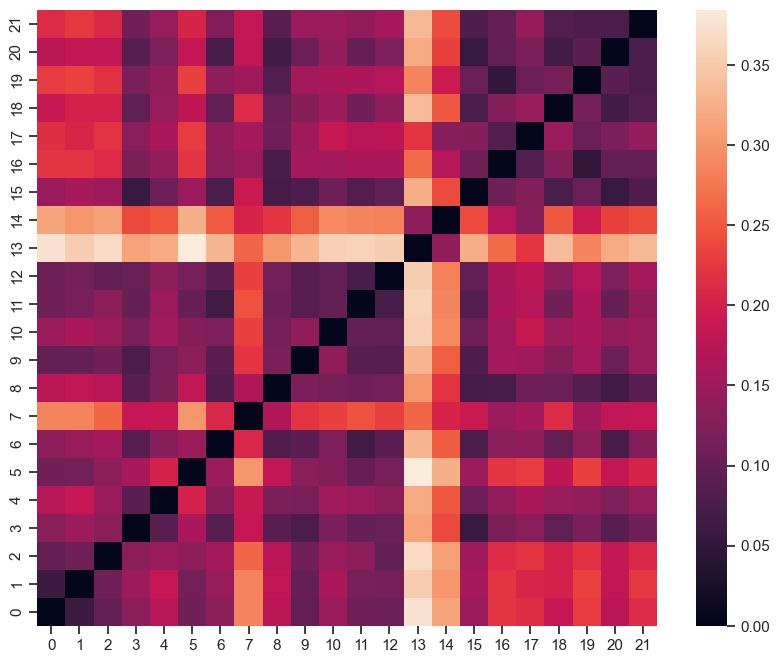

In [188]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    dist_mat,
    ax=ax,
)
ax.invert_yaxis()
fig.savefig(
    "./figures/distance_matrix.jpg",
    dpi=300,
    bbox_inches="tight",
)

# HDBSCAN

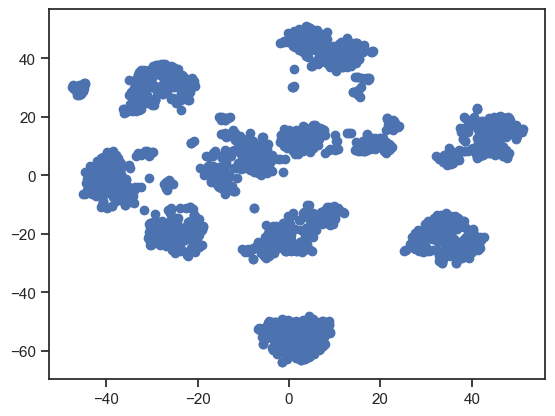

In [198]:
digits = load_digits()
data = digits.data
projection = TSNE().fit_transform(data)
plt.scatter(*projection.T)

/Users/rodolfofigueroa/Documents/urban_shape/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/rodolfofigueroa/Documents/urban_shape/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


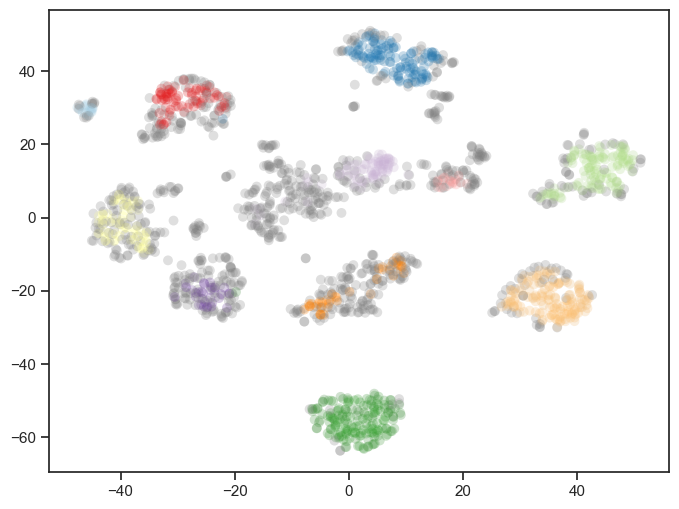

In [204]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette("Paired", 12)
cluster_colors = [
    color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_
]
cluster_member_colors = [
    sns.desaturate(x, p)
    for x, p in zip(cluster_colors, clusterer.probabilities_, strict=False)
]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
fig.savefig("./figures/hdbscan_clusters.jpg", dpi=300, bbox_inches="tight")